In [1]:
# =========================
# Celda 0 — SETUP (seed=42)
# =========================
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

import warnings, random, numpy as np, pandas as pd
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

RANDOM_STATE = 42
def _seed(s=RANDOM_STATE):
    random.seed(s); np.random.seed(s)
_seed()

FILES   = {"largo": ("AMZN_modelo_largo_train.csv", "target_504d_logret_fwd")}
SPLITS  = 5
GAP_MAP = {"largo": 504}

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def _rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def _mae (y, yhat): return float(mean_absolute_error(y, yhat))
def _r2  (y, yhat): return float(r2_score(y, yhat))
def _hit (y, yhat): return float((np.sign(y) == np.sign(yhat)).mean())

def load_xy(csv_path, target_col="target_504d_logret_fwd", date_col="Date"):
    df = pd.read_csv(csv_path)
    if date_col in df.columns:
        df = df.sort_values(date_col).reset_index(drop=True)
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if target_col not in df.columns:
        raise ValueError(f"No encuentro la columna objetivo: {target_col}")
    feats = [c for c in num_cols if c != target_col]
    X = df[feats].values
    y = df[target_col].values.astype(float)
    return df, X, y, feats

def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

from sklearn.base import clone
def eval_model_wf(estimator, X, y, splits):
    y_all, yhat_all = [], []
    for tr, va in splits:
        est = clone(estimator)
        est.fit(X[tr], y[tr])
        yh = est.predict(X[va])
        y_all.append(y[va]); yhat_all.append(yh)
    y_all = np.concatenate(y_all) if y_all else np.array([])
    yhat_all = np.concatenate(yhat_all) if yhat_all else np.array([])
    if y_all.size == 0:
        return {"rmse": np.nan, "mae": np.nan, "r2": np.nan, "hit": np.nan}
    return {
        "rmse": _rmse(y_all, yhat_all),
        "mae" : _mae (y_all, yhat_all),
        "r2"  : _r2  (y_all, yhat_all),
        "hit" : _hit (y_all, yhat_all),
    }

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
inner_cv = TimeSeriesSplit(n_splits=3)

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
LINEALES = {
    "OLS (ref)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     LinearRegression())
    ]),
    "Lasso(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     LassoCV(alphas=np.logspace(-4,0,25),
                            cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
    "ElasticNet(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.9],
                                 alphas=np.logspace(-4,0,25),
                                 cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
}

from sklearn.ensemble import RandomForestRegressor
RF_TUNED = RandomForestRegressor(
    n_estimators=500, max_depth=10, min_samples_leaf=5,
    max_features=0.7, bootstrap=True,
    random_state=RANDOM_STATE, n_jobs=1
)

try:
    from xgboost import XGBRegressor
    XGB_TUNED = XGBRegressor(
        n_estimators=800, max_depth=5, learning_rate=0.06,         # *** LARGO ***
        subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
        reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror",
        tree_method="hist", eval_metric="rmse",
        random_state=RANDOM_STATE, n_jobs=1, verbosity=0
    )
    ENABLE_XGB = True
except Exception:
    ENABLE_XGB = False

from sklearn.neural_network import MLPRegressor
def make_mlp_tuned(hidden=(64,), alpha=1e-5):
    return Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg",     MLPRegressor(
            hidden_layer_sizes=hidden, activation="tanh",
            solver="lbfgs", alpha=alpha,
            max_iter=20000, tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

try:
    import tensorflow as tf
    from tensorflow import keras
    TF_OK = True
    tf.get_logger().setLevel("ERROR")
    tf.keras.utils.set_random_seed(RANDOM_STATE)
except Exception:
    TF_OK = False

def _fit_imputer_scaler(Xtr):
    imp = SimpleImputer().fit(Xtr)
    sc  = StandardScaler().fit(imp.transform(Xtr))
    class PIPE:
        def __init__(self, imp, sc): self.imp, self.sc = imp, sc
        def transform(self, X): return self.sc.transform(self.imp.transform(X))
    return PIPE(imp, sc)

def _build_seq(X, y, lookback=20):
    n, d = X.shape
    if n <= lookback: return np.zeros((0, lookback, d)), np.zeros((0,))
    Xs = np.array([X[i-lookback:i] for i in range(lookback, n)])
    ys = y[lookback:n]
    return Xs, ys

def make_gru(input_shape, units=64, l2=1e-3, dropout=0.1):
    reg = keras.regularizers.l2(l2)
    inp = keras.layers.Input(shape=input_shape)
    x = keras.layers.GRU(units, kernel_regularizer=reg, recurrent_regularizer=reg,
                         dropout=dropout, return_sequences=False)(inp)
    out = keras.layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return m


In [ ]:
# ======================================
# Celda 1 — LARGO (≈504 días): evaluación
# ======================================
csv_path, target_col = FILES["largo"]
gap = GAP_MAP["largo"]

# Datos
df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
N = len(df_raw)

# Geometría (como en TrainModels) + fallback si no caben folds
val_size  = max(50, N // 12)        # ~62 para N~749
train_min = max(200, val_size * 2)
splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

# Fallback EXACTO de TrainModels: val_size_alt=22
if len(splits) == 0:
    val_size  = 22
    train_min = max(200, val_size * 2)
    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

# --- baseline(media) usando los splits (recalcular tras fallback)
YBAR = float(np.mean(y))
y_val_all = np.concatenate([y[va] for _, va in splits]) if len(splits) else np.array([])
RMSE_MEDIA = float(np.sqrt(np.mean((y_val_all - YBAR)**2))) if y_val_all.size else np.nan

# --- catálogo de modelos (todos “tuned”, OLS referencia)
modelos = []
modelos.append(("OLS (ref)", LINEALES["OLS (ref)"]))
modelos.append(("Lasso(tuned)", LINEALES["Lasso(tuned)"]))
modelos.append(("ElasticNet(tuned)", LINEALES["ElasticNet(tuned)"]))
modelos.append(("RF(tuned)", RF_TUNED))
if ENABLE_XGB: modelos.append(("XGB(tuned)", XGB_TUNED))
modelos.append(("MLP(tuned)", make_mlp_tuned(hidden=(64,), alpha=1e-5)))

rows = []

# --- evaluación sklearn-like (WF purgado)
for nombre, est in modelos:
    m = eval_model_wf(est, X, y, splits)
    rows.append({
        "modelo": nombre,
        "rmse": m["rmse"], "mae": m["mae"], "r2": m["r2"], "hit": m["hit"],
        "skill_vs_media": (1.0 - m["rmse"]/RMSE_MEDIA) if RMSE_MEDIA > 0 else np.nan
    })

# --- GRU (tuned), si hay TF cargado en Celda 0
if TF_OK:
    y_all, yhat_all = [], []
    for tr, va in splits:
        sc = _fit_imputer_scaler(X[tr])
        Xtr_s, Xva_s = sc.transform(X[tr]), sc.transform(X[va])

        # secuencias con lookback=20 (igual que en corto/medio)
        Xtr_seq, ytr = _build_seq(Xtr_s, y[tr], lookback=20)
        Xva_seq, yva = _build_seq(Xva_s, y[va], lookback=20)
        if Xtr_seq.shape[0] == 0 or Xva_seq.shape[0] == 0:
            continue

        nseq = Xtr_seq.shape[0]
        cut = max(1, int(0.8 * nseq))
        Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
        val_data = (Xtr_seq[cut:], ytr[cut:]) if cut < nseq else None

        gru = make_gru(input_shape=Xtr_seq.shape[1:], units=64, l2=1e-3, dropout=0.1)
        cb = []
        if val_data is not None:
            cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
        gru.fit(Xtr_i, ytr_i, epochs=150, batch_size=64, verbose=0, validation_data=val_data, callbacks=cb)

        yhat = gru.predict(Xva_seq, verbose=0).ravel()
        y_all.append(yva); yhat_all.append(yhat)

    if y_all:
        y_all = np.concatenate(y_all); yhat_all = np.concatenate(yhat_all)
        rm_gru = _rmse(y_all, yhat_all); mae_gru = _mae(y_all, yhat_all)
        r2_gru = _r2(y_all, yhat_all); hit_gru = _hit(y_all, yhat_all)
        rows.append({
            "modelo": "GRU(tuned)",
            "rmse": rm_gru, "mae": mae_gru, "r2": r2_gru, "hit": hit_gru,
            "skill_vs_media": (1.0 - rm_gru/RMSE_MEDIA) if RMSE_MEDIA > 0 else np.nan
        })
    else:
        rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})
else:
    rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})

# --- baseline(media) como fila
import pandas as pd
from sklearn.metrics import r2_score
base_df = pd.DataFrame([{
    "modelo": "Baseline(media)",
    "rmse": RMSE_MEDIA,
    "mae":  float(np.mean(np.abs(y_val_all - YBAR))) if y_val_all.size else np.nan,
    "r2":   float(r2_score(y_val_all, np.full_like(y_val_all, YBAR))) if y_val_all.size else np.nan,
    "hit":  float((np.sign(y_val_all) == np.sign(YBAR)).mean()) if y_val_all.size else np.nan,
    "skill_vs_media": 0.0
}])

# --- TABLA FINAL ORDENADA POR RMSE
res_largo = pd.concat([pd.DataFrame(rows), base_df], ignore_index=True).sort_values("rmse").reset_index(drop=True)
res_largo


,modelo,rmse,mae,r2,hit,skill_vs_media
0,XGB(tuned),0.041240,0.030559,0.993122,1.000000,0.917076
1,RF(tuned),0.059513,0.045791,0.985677,0.977273,0.880334
2,OLS (ref),0.076233,0.064459,0.976498,0.954545,0.846713
3,Lasso(tuned),0.084093,0.070945,0.971403,0.977273,0.830910
4,ElasticNet(tuned),0.084142,0.070975,0.971369,0.977273,0.830810
5,MLP(tuned),0.088959,0.056303,0.967997,0.977273,0.821124
6,Baseline(media),0.497325,0.450148,-0.000209,0.545455,0.000000
7,GRU(tuned),0.513889,0.416417,0.154405,0.750000,-0.033306


In [ ]:
# ======================================================
# Celda 2 — Guardar mejor (504 d) + baseline + predict()
# ======================================================
from joblib import dump, load
import pandas as pd
import numpy as np

# Identifica el ganador por RMSE (excluye explícitamente el baseline)
tabla_sin_base = res_largo[res_largo["modelo"] != "Baseline(media)"].copy()
ganador = tabla_sin_base.iloc[0]["modelo"]
print("Mejor modelo (504 d):", ganador)

# Reinstancia el estimador ganador con la misma config
def _get_estimator_by_name(name):
    if name == "OLS (ref)":         return LINEALES["OLS (ref)"]
    if name == "Lasso(tuned)":      return LINEALES["Lasso(tuned)"]
    if name == "ElasticNet(tuned)": return LINEALES["ElasticNet(tuned)"]
    if name == "RF(tuned)":         return RF_TUNED
    if name == "XGB(tuned)":        return XGB_TUNED
    if name == "MLP(tuned)":        return make_mlp_tuned(hidden=(64,), alpha=1e-5)
    raise ValueError(f"Desconocido: {name}")

best_est = _get_estimator_by_name(ganador)

# Carga los datos (como en el corto/medio: X será DataFrame, feats lista)
csv_path, target_col = FILES["largo"]
df_raw = pd.read_csv(csv_path)
if "Date" in df_raw.columns:
    df_raw = df_raw.sort_values("Date").reset_index(drop=True)
num_cols = df_raw.select_dtypes(include=["number"]).columns.tolist()
assert target_col in df_raw.columns, f"Falta columna objetivo: {target_col}"
feats = [c for c in num_cols if c != target_col]
X_df = df_raw[feats]
y = df_raw[target_col]

# Fit final 
best_est.fit(X_df, y)

try:
    booster = best_est.get_booster()              # XGBRegressor
    print("XGB feature_names (primeras):", booster.feature_names[:5])
except Exception:
    print("No es XGB o no expone feature_names (ok).")

# Guardar modelo y baseline
MODEL_PATH = "model_504d.joblib"
dump(best_est, MODEL_PATH)

MEDIA_504D = float(y.mean())
with open("baseline_504d_media.txt", "w") as f:
    f.write(str(MEDIA_504D))

print(f"Modelo guardado en: {MODEL_PATH}")
print(f"Baseline media (504 d): {MEDIA_504D:.6f}")

def predict_504d(df_features):
    model = load(MODEL_PATH)
    X_inf = df_features[feats]   
    return model.predict(X_inf)

def predict_504d_media(n):
    with open("baseline_504d_media.txt") as f:
        mu = float(f.read().strip())
    return np.full(n, mu, dtype=float)


Mejor modelo (504 d): XGB(tuned)
XGB feature_names (primeras): ['close', 'volume', 'roc_1260', 'dist_sma50', 'dist_sma200']
Modelo guardado en: model_504d.joblib
Baseline media (504 d): 0.127710


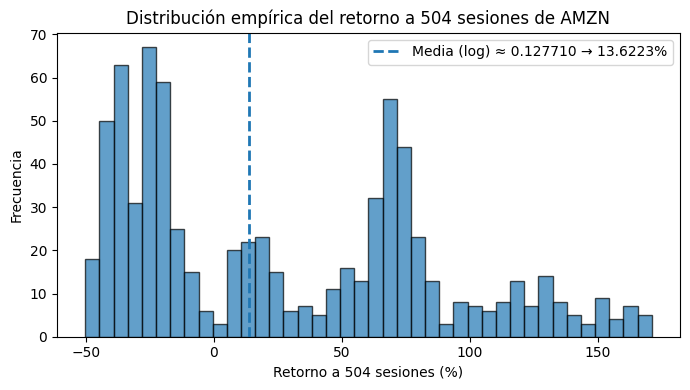

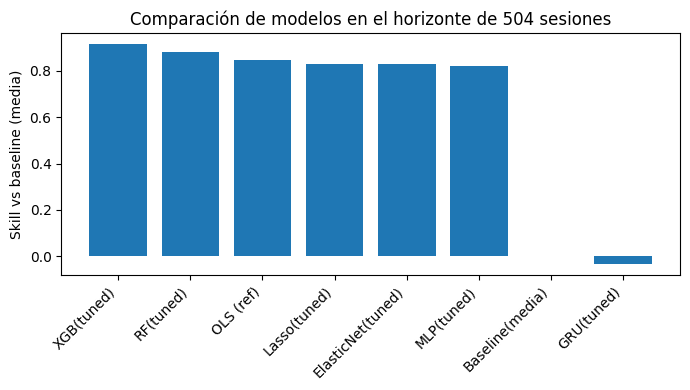

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ==============================
# Figura: histograma 504 días
# ==============================
rets_log_504 = y  # target_504d_logret_fwd
rets_pct_504 = (np.exp(rets_log_504) - 1.0) * 100.0

mu_504 = MEDIA_504D
mu_pct_504 = (math.exp(mu_504) - 1.0) * 100.0

plt.figure(figsize=(7, 4))
plt.hist(rets_pct_504, bins=40, edgecolor="black", alpha=0.7)
plt.axvline(mu_pct_504, color="tab:blue", linestyle="--", linewidth=2)

plt.title("Distribución empírica del retorno a 504 sesiones de AMZN")
plt.xlabel("Retorno a 504 sesiones (%)")
plt.ylabel("Frecuencia")

plt.legend([f"Media (log) ≈ {mu_504:.6f} → {mu_pct_504:.4f}%"])
plt.tight_layout()
plt.show()

# =========================================
# Figura: skill vs baseline para 504 días
# =========================================
res_plot_504 = res_largo.copy()

# Ordenamos por skill descendente
res_plot_504 = res_plot_504.sort_values("skill_vs_media", ascending=False)

plt.figure(figsize=(7, 4))
plt.bar(res_plot_504["modelo"], res_plot_504["skill_vs_media"])

plt.title("Comparación de modelos en el horizonte de 504 sesiones")
plt.ylabel("Skill vs baseline (media)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [5]:
# Celda extra — Importancias globales XGB (504 d)
from joblib import load
import pandas as pd

csv_path, target_col = FILES["largo"]
df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)

model_504d = load("model_504d.joblib")

importances_504d = pd.DataFrame({
    "feature": feats,
    "importance": model_504d.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 20 features XGB (504 d):")
print(importances_504d.head(20))

importances_504d.to_csv("xgb_importances_504d.csv", index=False)


Top 20 features XGB (504 d):
               feature  importance
8             from_ath    0.528580
2             roc_1260    0.344910
5          dist_sma400    0.031726
0                close    0.029647
7         from_52w_low    0.018186
12  vol_ratio_252_1260    0.018010
9        drawdown_long    0.008110
17       news_std_w126    0.007037
16      news_mean_w126    0.003840
6        from_52w_high    0.003242
13       hv_yz_270_ext    0.002695
11      trend_slope_3y    0.001799
4          dist_sma200    0.000578
14      iv_atm_360_ext    0.000491
15  iv_ts_ratio_30_360    0.000484
3           dist_sma50    0.000304
10            trend_ok    0.000273
1               volume    0.000089
